In [12]:
#| default_exp curves
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from sympy import *
from typing import Tuple
from functools import partial
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analytically Producing Curvature Curves

## Entropy of an n-d Gaussian

In [13]:
import sympy
from sympy import symbols, integrate
def nd_euclidean_heat_kernel(
    dimension:int,
    time:float
)->Tuple[sympy.core.mul.Mul,tuple]:
    # defines a sympy function with given parameters, suitable for integration
    # this is a somewhat hacky way to integrate over a higher dimension 
    vector_variables = ['x'+str(i) for i in range(dimension)]
    vector_variables_str = ''
    for vv in vector_variables: vector_variables_str += vv + ' '
    xs = symbols(vector_variables_str)
    # construct expression for norm of xs
    vars_sqrd = [var**2 for var in xs]
    norm_of_xs = 0
    for v in vars_sqrd:
        norm_of_xs += v
    # Construct multidimensional gaussian with given time
    K = (1/(4*sympy.pi*time)**(dimension/2))*sympy.exp((-norm_of_xs)/(4*time))
    return K, xs


We can verify that the general form is correct, i.e. the $K$ returned by this equation is the euclidean heat kernel:

$$K(t, x, y)=\exp (t \Delta)(x, y)=\frac{1}{(4 \pi t)^{d / 2}} e^{-\|x-y\|^2 / 4 t} \quad\left(x, y \in \mathbb{R}^d, t>0\right)$$

Here's a function with the parameters time and dimension supplied, for downstream analysis:

In [14]:
K, xs = nd_euclidean_heat_kernel(dimension=2,time=5)

In [15]:
# integrate the heat kernel
from sympy import integrate, oo
I = K
for x in xs:
    I = integrate(I,(x, -oo, oo))

The heat kernel should always integrate to 1.

In [16]:
assert np.allclose(float(I),1.0)

In [17]:
# integrate the heat kernel
from sympy import integrate, oo
I = K
for x in xs:
    I = integrate(I,(x, -oo, oo))

In [18]:
def entropy_of_nd_euclidean_heat_kernel(
    time:float, # the bandwidth of the heat kernel
    dimension:int,
):
    K, xs = nd_euclidean_heat_kernel(dimension=dimension, time=time)
    entropy_integrand = K*sympy.ln(K)
    I = entropy_integrand
    for x in xs:
        I = integrate(I,(x, -oo, oo))
    return -I # TODO: Could milk more precision by staying in sympy format

In [19]:
entropy_of_nd_euclidean_heat_kernel(dimension=2,time=1)

1.0*log(pi) + 2.38629436111989

In [20]:
t = symbols('t')
I_dynamic = entropy_of_nd_euclidean_heat_kernel(time=t, dimension=2)
I_dynamic

-0.346573590279973*(1.0*Integral(exp(-x1**2/(4*t))*Integral(-0.721347520444482*exp(-x0**2/(4*t))*log(pi), (x0, -oo, oo)), (x1, -oo, oo)) + 1.0*Integral(exp(-x1**2/(4*t))*Integral(0.721347520444482*exp(-x0**2/(4*t))*log(exp(-x0**2/(4*t))*exp(-x1**2/(4*t))/t**1.0), (x0, -oo, oo)), (x1, -oo, oo)) + 1.0*Integral(exp(-x1**2/(4*t))*Integral(-1.0*exp(-x0**2/(4*t)), (x0, -oo, oo)), (x1, -oo, oo)))/(pi**1.0*t**1.0)

In [21]:
I_dynamic.simplify()

Piecewise(((1.0*pi*t**2*log(pi) + 1.38629436111989*pi*t**2 - 0.25*polar_lift(t)*Integral(exp(-x1**2/(4*t))*Integral(exp(-x0**2/(4*t))*log(exp(-(x0**2 + x1**2)/(4*t))/t**1.0), (x0, -oo, oo)), (x1, -oo, oo)))/(pi**1.0*t**1.0*polar_lift(t)), Abs(arg(t)) <= pi/2), ((-0.25*Integral(exp(-x1**2/(4*t))*Integral(exp(-x0**2/(4*t))*log(exp(-(x0**2 + x1**2)/(4*t))/t**1.0), (x0, -oo, oo)), (x1, -oo, oo)) + 0.25*log(pi)*Integral(exp(-x0**2/(4*t)), (x0, -oo, oo))*Integral(exp(-x1**2/(4*t)), (x1, -oo, oo)) + 0.346573590279973*Integral(exp(-x0**2/(4*t)), (x0, -oo, oo))*Integral(exp(-x1**2/(4*t)), (x1, -oo, oo)))/(pi**1.0*t**1.0), True))

Let's see what these curves look like over time:

In [22]:
def analytic_curvature_curve(dimension:int, max:float=50):
    ts = np.arange(0.1,max,step=0.1)
    entropy_of_dim_at_time = partial(entropy_of_nd_euclidean_heat_kernel,dimension=dimension)
    entropies_at_times = list(map(entropy_of_dim_at_time,ts)) # TODO: this is code-golfy. Faster methods surely exist.
    return entropies_at_times

In [23]:
entropies_over_time_analytic = analytic_curvature_curve(dimension=2)

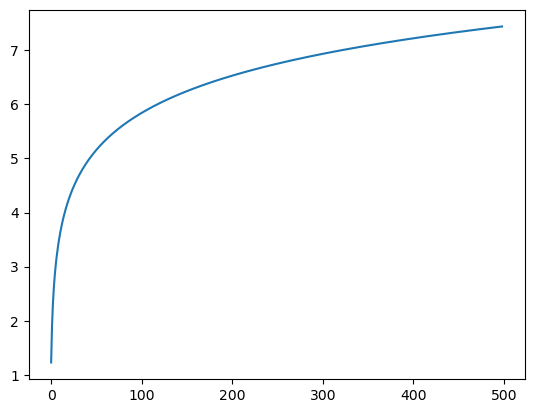

In [24]:
plt.plot(entropies_over_time_analytic)

# Comparison to the discrete case

In [25]:
from diffusion_curvature.comparisons import diffusion_entropy_of_noise
def curvature_curve_of_sampled_euclidean_space(
        dimension:int,
        n_flat_samples = 2000
):
    ts = np.arange(1,32,step=1)
    entropies = []
    for t in tqdm(ts):
        # for robustness, we'll average several measurements
        en = []
        for i in range(5):
            en.append(diffusion_entropy_of_noise(dimension=dimension,t=t,n_flat_samples=n_flat_samples))
        entropies.append(
            np.mean(en)
        )
    return entropies

In [26]:
entropies_over_time_discrete = curvature_curve_of_sampled_euclidean_space(dimension=2)

  0%|          | 0/31 [00:00<?, ?it/s]

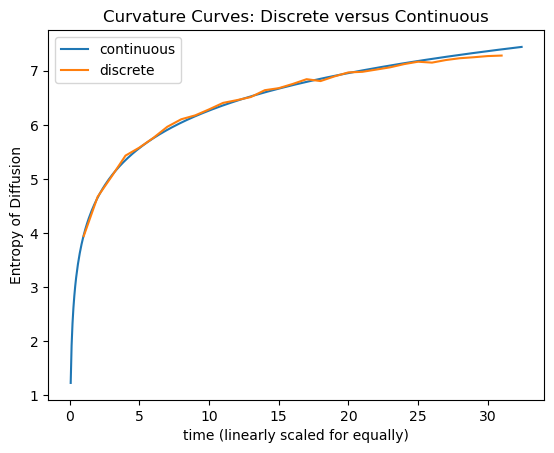

In [37]:
plt.plot(np.arange(0.1,50,step=0.1)*0.65, entropies_over_time_analytic, label="continuous")
plt.plot(np.arange(1,32,step=1), entropies_over_time_discrete, label="discrete")
plt.xlabel("time (linearly scaled for equally)")
plt.ylabel("Entropy of Diffusion")
plt.title("Curvature Curves: Discrete versus Continuous")
plt.legend()

So scaling the curvature curve by a constant allows it to fit the flat data nearly perfectly. This suggests that diffusion in the discrete case happens faster in the discrete case. Incrementing t by the power t $1$ is similar to incrementing the bandwidth by 1.5

## Performing the scaling automatically
In the above case, we found that compressing the continuous case by 1.5 matched the data pretty well. But this constant surely isn't universal, and will change depending on the kernel bandwidth settings used when constructing the initial graph.

For now, we'll use the naive fitting method of just trying a bunch of scaling values and choosing the one that fits best.

In [40]:
def scale_curves(x1, y1, x2, y2):
    """Linearly transform the x1 values to minimize the difference between y2 and y1.
    Assumes that x1 is sampled more frequently than x2, such that for every scaling, a close value to each x2 can be found in the scaled x1
    """
    scale_factors = np.arange(0.1,4,0.01) # TODO: These ranges are kind of arbitrary.
    associated_diffs = []
    for s in scale_factors:
        x1_scaled = x1 * s
        diffs = 0
        for i, x in enumerate(x2):
            matching_x1_idx = np.argmin(np.abs(np.array(x1_scaled) - x))
            dist = np.abs(float(y1[matching_x1_idx] - y2[i]))
            diffs += dist
        associated_diffs.append(diffs)
    best_diff_idx = np.argmin(associated_diffs)
    return scale_factors[best_diff_idx]

In [39]:
scale_curves(np.arange(0.1,50,step=0.1), entropies_over_time_analytic, np.arange(1,32,step=1), entropies_over_time_discrete)

0.6499999999999997

Nice, this works on our one test case.

## Fitting to the Sphere and Saddle
We've now found that, by linear scaling, we can transform the analytically derived curvature curve to closely fit the discretely sampled curvature curve.

The glaring question is: *Is this unique to euclidean data?* Could we apply some transformation to obtain an equally close fit for spherical or hyperbolic data?

To test this, we'll bring out two manifolds of differing curvature and compare the curvature curves.

In [41]:
from diffusion_curvature.datasets import sphere, paraboloid
X_sphere, ks_sphere = sphere(n=2000,use_guide_points=True)
X_saddle, ks_saddle = paraboloid(n=2000, use_guide_points=True)

In [42]:
from diffusion_curvature.comparisons import diffusion_entropy_curvature_of_data
def rate_of_change_of_entropy(X, k = 10, max=32):
    ts = list(range(1,max))
    entropies = np.empty((len(X),len(ts)))
    for idx, t in tqdm(enumerate(ts)):
        entropies[:,idx] = diffusion_entropy_curvature_of_data(X,t, k=k)
    return entropies

In [43]:
entropies_of_sphere = rate_of_change_of_entropy(X_sphere)

0it [00:00, ?it/s]

In [44]:
entropies_of_saddle = rate_of_change_of_entropy(X_saddle)

0it [00:00, ?it/s]

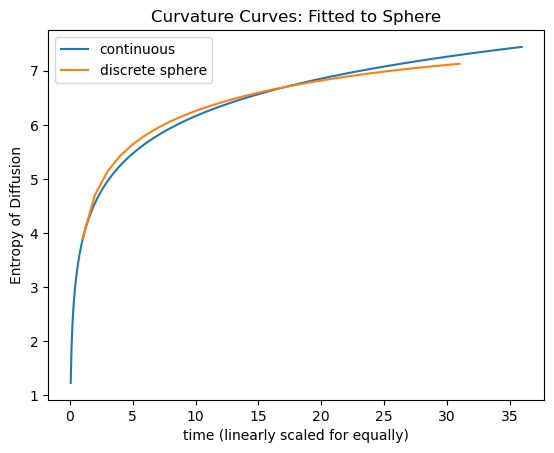

In [54]:
es = entropies_of_sphere[0]
scaling_factor_sphere = scale_curves(
    x1 = np.arange(0.1,50,step=0.1), 
    y1 = entropies_over_time_analytic, 
    x2 = np.arange(1,32,step=1), 
    y2 = es
    )
plt.plot(np.arange(0.1,50,step=0.1)*scaling_factor_sphere, entropies_over_time_analytic, label="continuous")
plt.plot(np.arange(1,32,step=1), es, label="discrete sphere")
plt.xlabel("time (linearly scaled for equally)")
plt.ylabel("Entropy of Diffusion")
plt.title("Curvature Curves: Fitted to Sphere")
plt.legend()

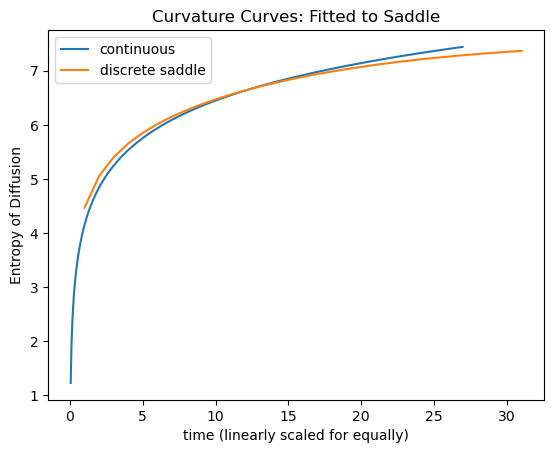

In [55]:
es = entropies_of_saddle[0]
scaling_factor_saddle = scale_curves(
    x1 = np.arange(0.1,50,step=0.1), 
    y1 = entropies_over_time_analytic, 
    x2 = np.arange(1,32,step=1), 
    y2 = es
    )
plt.plot(np.arange(0.1,50,step=0.1)*scaling_factor_saddle, entropies_over_time_analytic, label="continuous")
plt.plot(np.arange(1,32,step=1), es, label="discrete saddle")
plt.xlabel("time (linearly scaled for equally)")
plt.ylabel("Entropy of Diffusion")
plt.title("Curvature Curves: Fitted to Saddle")
plt.legend()

In [56]:
from diffusion_curvature.datasets import plane
X_plane = plane(2000)

In [61]:
entropies_of_plane = rate_of_change_of_entropy(X_plane,k=20)

0it [00:00, ?it/s]

using scaling factor 0.3099999999999999


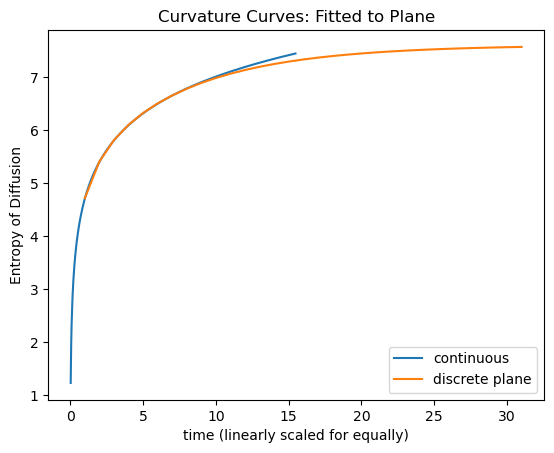

In [62]:
es = entropies_of_plane[0]
scaling_factor_plane = scale_curves(
    x1 = np.arange(0.1,50,step=0.1), 
    y1 = entropies_over_time_analytic, 
    x2 = np.arange(1,32,step=1), 
    y2 = es
    )
print("using scaling factor",scaling_factor_plane)
plt.plot(np.arange(0.1,50,step=0.1)*scaling_factor_plane, entropies_over_time_analytic, label="continuous")
plt.plot(np.arange(1,32,step=1), es, label="discrete plane")
plt.xlabel("time (linearly scaled for equally)")
plt.ylabel("Entropy of Diffusion")
plt.title("Curvature Curves: Fitted to Plane")
plt.legend()

Out of curiosity, let's overlay everything on one plot to see how well the scales transfer between datasets:

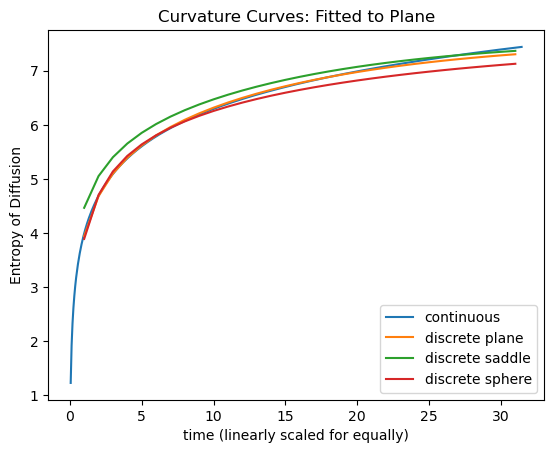

In [59]:
plt.plot(np.arange(0.1,50,step=0.1)*scaling_factor_plane, entropies_over_time_analytic, label="continuous")
plt.plot(np.arange(1,32,step=1), entropies_of_plane[0], label="discrete plane")
plt.plot(np.arange(1,32,step=1), entropies_of_saddle[0], label="discrete saddle")
plt.plot(np.arange(1,32,step=1), entropies_of_sphere[0], label="discrete sphere")
plt.xlabel("time (linearly scaled for equally)")
plt.ylabel("Entropy of Diffusion")
plt.title("Curvature Curves: Fitted to Plane")
plt.legend()